In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip

Archive:  sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
import os
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import csv
sentences = []
with open('/content/training.1600000.processed.noemoticon.csv', 'r', errors = 'ignore') as f:
    csv_reader = csv.reader(f)
    for row in csv_reader:
        sentences.append(row[5])
print(sentences[:5])

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 'my whole body feels itchy and like its on fire ', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]


In [ ]:
import pandas as pd
data_text = pd.DataFrame(sentences)
data_text.head()

,0
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data_text['index'] = data_text.index
documents = data_text
documents.head()

,0,index
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,1
2,@Kenichan I dived many times for the ball. Man...,2
3,my whole body feels itchy and like its on fire,3
4,"@nationwideclass no, it's not behaving at all....",4


Another approach

In [ ]:
!pip3 install pyLDAvis

In [ ]:
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [ ]:
# Convert to list
data = sentences

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['http://twitpic.com/2y1zl - Awww, thats a bummer. You shoulda got David Carr '
 'of Third Day to do it. ;D']


In [ ]:
data[0] = ' Awww, thats a bummer. You shoulda got David Carr of Third Day to do it.'

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [ ]:
speaker = data[:50000]
speaker[:4]

[' Awww, thats a bummer. You shoulda got David Carr of Third Day to do it.',
 'is upset that he cant update his Facebook by texting it... and might cry as a result School today also. Blah!',
 'I dived many times for the ball. Managed to save 50% The rest go out of bounds',
 'my whole body feels itchy and like its on fire ']

In [ ]:
print(len(speaker))

50000


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(speaker))

print(data_words[:5])

[['awww', 'thats', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it'], ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'result', 'school', 'today', 'also', 'blah'], ['dived', 'many', 'times', 'for', 'the', 'ball', 'managed', 'to', 'save', 'the', 'rest', 'go', 'out', 'of', 'bounds'], ['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire'], ['no', 'its', 'not', 'behaving', 'at', 'all', 'im', 'mad', 'why', 'am', 'here', 'because', 'cant', 'see', 'you', 'all', 'over', 'there']]


In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['awww', 'thats', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it']


In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['get', 'third', 'day']]


In [ ]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
print(id2word[0])

[[(0, 1), (1, 1), (2, 1)]]
day


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('day', 1), ('get', 1), ('third', 1)]]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-07-04 15:48:48--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  10.4MB/s    in 1.5s    

2020-07-04 15:48:50 (10.4 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
!unzip /content/mallet-2.0.8.zip

Archive:  /content/mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.cla

In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=50, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
pprint(lda_model.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamodel = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamodel = coherence_model_ldamodel.get_coherence()
print('\nCoherence Score: ', coherence_ldamodel)

[(47,
  [('life', 0.08215824),
   ('laptop', 0.058189988),
   ('cool', 0.048894543),
   ('dream', 0.047724307),
   ('date', 0.034788042),
   ('news', 0.03299102),
   ('knee', 0.024971317),
   ('arrive', 0.023070686),
   ('dad', 0.020975914),
   ('issue', 0.020819806)]),
 (12,
  [('never', 0.19868034),
   ('talk', 0.09248915),
   ('anymore', 0.05790894),
   ('hand', 0.04472145),
   ('dude', 0.03551129),
   ('door', 0.03105274),
   ('half', 0.031009316),
   ('asleep', 0.02134909),
   ('machine', 0.020090308),
   ('painful', 0.01948455)]),
 (0,
  [('happen', 0.116272464),
   ('probably', 0.06619439),
   ('report', 0.028280905),
   ('fix', 0.027340949),
   ('expensive', 0.026729709),
   ('bamboozle', 0.026050838),
   ('brain', 0.024717072),
   ('tear', 0.023319045),
   ('search', 0.022291794),
   ('red', 0.021798408)]),
 (24,
  [('sick', 0.17714775),
   ('little', 0.12561111),
   ('better', 0.07596922),
   ('busy', 0.065254524),
   ('hangover', 0.042791694),
   ('brother', 0.02400648),
   

In [ ]:
model_topics = lda_model.show_topics()
pprint(lda_model.print_topics(num_words=100, num_topics = 50))

[(0,
  '0.116*"happen" + 0.066*"probably" + 0.028*"report" + 0.027*"fix" + '
  '0.027*"expensive" + 0.026*"bamboozle" + 0.025*"brain" + 0.023*"tear" + '
  '0.022*"search" + 0.022*"red" + 0.020*"chicken" + 0.018*"afford" + '
  '0.018*"law" + 0.018*"copy" + 0.017*"chocolate" + 0.014*"self" + '
  '0.014*"damage" + 0.014*"concert" + 0.014*"struggle" + 0.012*"continue" + '
  '0.011*"garage" + 0.011*"studio" + 0.011*"please" + 0.010*"left" + '
  '0.010*"fridge" + 0.010*"power" + 0.010*"junk" + 0.008*"wireless" + '
  '0.008*"darn" + 0.007*"ballet" + 0.006*"student" + 0.006*"scrub" + '
  '0.006*"knock" + 0.006*"bailey" + 0.006*"attack" + 0.006*"anxiety" + '
  '0.005*"slowly" + 0.005*"snap" + 0.005*"anger" + 0.005*"lost" + '
  '0.005*"twitterfon" + 0.005*"shake" + 0.005*"model" + 0.004*"loop" + '
  '0.004*"dot" + 0.004*"needless" + 0.004*"cider" + 0.004*"clone" + '
  '0.004*"cracker" + 0.004*"freezing" + 0.004*"arrest" + 0.004*"diabetes" + '
  '0.003*"chinese" + 0.003*"accidently" + 0.003*"tack

In [ ]:
print(lda_model[corpus][0])

([(0, 0.01219804), (1, 0.018083902), (2, 0.023663264), (3, 0.016492624), (4, 0.019410752), (5, 0.013967323), (6, 0.016151246), (7, 0.01987606), (8, 0.028394517), (9, 0.017470544), (10, 0.09511486), (11, 0.01508251), (12, 0.011973749), (13, 0.025148446), (14, 0.013436125), (15, 0.01604263), (16, 0.0170215), (17, 0.019185849), (18, 0.016838511), (19, 0.016124338), (20, 0.015966719), (21, 0.030927261), (22, 0.020453148), (23, 0.020991482), (24, 0.012251973), (25, 0.05168757), (26, 0.016882725), (27, 0.035859052), (28, 0.012645853), (29, 0.014837838), (30, 0.01472482), (31, 0.013803079), (32, 0.017304042), (33, 0.015184958), (34, 0.014317924), (35, 0.013052799), (36, 0.013992627), (37, 0.028844709), (38, 0.016878333), (39, 0.013158458), (40, 0.017450176), (41, 0.016819809), (42, 0.018039115), (43, 0.015305056), (44, 0.018097106), (45, 0.018606342), (46, 0.018932898), (47, 0.010819064), (48, 0.024486093), (49, 0.016002188)], [(0, [10]), (1, [25]), (2, [10])], [(0, [(10, 1.0)]), (1, [(25, 1.

In [ ]:
import pickle

In [ ]:
from gensim.test.utils import datapath

# Save model to disk.
lda_model.save('lda_non_mallet_model')
# Load a potentially pretrained model from disk.

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
import pickle

with open('id2word2.pickle', 'wb') as f:
  pickle.dump(id2word, f)
with open('corpus2.pickle', 'wb') as f:
  pickle.dump(corpus, f)
with open('lda_non_mallet.pickle', 'wb') as f:
  pickle.dump(lda_model, f)

###IGNORE BELLOW


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=100, step=5)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=60, id2word=id2word)

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(8,
  '0.088*"evidence" + 0.077*"care" + 0.051*"problem" + 0.050*"pay" + '
  '0.035*"fine" + 0.033*"protect" + 0.026*"exactly" + 0.019*"weapon" + '
  '0.019*"shut" + 0.016*"scratch"'),
 (18,
  '0.104*"great" + 0.081*"knife" + 0.078*"mile" + 0.036*"heart" + 0.034*"wave" '
  '+ 0.030*"power" + 0.029*"finger" + 0.028*"watch" + 0.026*"world" + '
  '0.024*"almost"'),
 (22,
  '0.115*"work" + 0.068*"cut" + 0.061*"tomorrow" + 0.049*"easy" + 0.048*"head" '
  '+ 0.041*"fight" + 0.027*"building" + 0.025*"late" + 0.019*"play" + '
  '0.019*"around"'),
 (17,
  '0.288*"let" + 0.069*"first" + 0.037*"district" + 0.034*"hunt" + '
  '0.029*"drive" + 0.027*"follow" + 0.025*"test" + 0.022*"bit" + 0.020*"sick" '
  '+ 0.019*"amazing"'),
 (12,
  '0.281*"think" + 0.084*"last" + 0.061*"move" + 0.046*"real" + 0.038*"like" + '
  '0.038*"hurt" + 0.025*"spend" + 0.023*"duty" + 0.017*"patient" + '
  '0.017*"trouble"'),
 (15,
  '0.461*"come" + 0.037*"hour" + 0.032*"morning" + 0.029*"leg" + 0.027*"house" '
  '+ 0.025

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.071902566972863

Coherence Score:  0.5930349245596628


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.261155  0.055390       1        1  7.723295
20    -0.128490  0.055882       2        1  5.467756
11    -0.168184 -0.328665       3        1  5.236248
19    -0.091898  0.003480       4        1  4.818011
6     -0.066562  0.079879       5        1  4.698287
23    -0.096832  0.139014       6        1  4.588589
13     0.008064  0.045020       7        1  4.386479
9      0.015730  0.033223       8        1  4.239855
0     -0.039478  0.019196       9        1  4.073724
7      0.002755 -0.015200      10        1  3.971724
2     -0.000511  0.010616      11        1  3.890028
16     0.021103  0.032269      12        1  3.879804
24     0.065814 -0.173486      13        1  3.787091
3      0.042663  0.022058      14        1  3.725099
1      0.044968  0.021990      15        1  3.693241
10     0.081932 -0.072225      16        1  3.658542
21     0.049583  0.015267      17        1  3.576164
14    -0.007070  0.019602      18        1  3.459841
4      0.048491  0.031443      19        1  3.436601
15     0.048540  0.021316      20        1  3.310711
12     0.057310  0.017442      21        1  3.305533
17     0.076208  0.015013      22        1  2.978163
22     0.109337 -0.024086      23        1  2.886471
18     0.099248 -0.038436      24        1  2.646462
8      0.088435  0.013998      25        1  2.562277, topic_info=           Term          Freq         Total Category  logprob  loglift
3            go  11497.000000  11497.000000  Default  30.0000  30.0000
23         know   8127.000000   8127.000000  Default  29.0000  29.0000
30         come   6736.000000   6736.000000  Default  28.0000  28.0000
57          get   7036.000000   7036.000000  Default  27.0000  27.0000
14         want   5494.000000   5494.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1200        win     88.595055     89.602516  Topic25  -4.8496   3.6530
2018       male     84.431786     85.439247  Topic25  -4.8977   3.6524
634       alive     83.889160     84.896622  Topic25  -4.9041   3.6523
3927  elsewhere    133.411209    169.629028  Topic25  -4.4402   3.4241
5338  policeman     89.426140    415.065247  Topic25  -4.8402   2.1293

[830 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
812      21  0.982428    abandon
439      21  0.995011    ability
542      17  0.998017       able
5576      1  0.049420   absolute
5576      3  0.057657   absolute
...     ...       ...        ...
48       17  0.996228      write
326      13  0.997588      wrong
330      13  0.999491       year
2650     15  0.994153  yesterday
245       9  0.999367        yet

[1221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 21, 12, 20, 7, 24, 14, 10, 1, 8, 3, 17, 25, 4, 2, 11, 22, 15, 5, 16, 13, 18, 23, 19, 9])

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-07-02 08:54:03--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  15.2MB/s    in 1.0s    

2020-07-02 08:54:05 (15.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
!unzip /content/mallet-2.0.8.zip

Archive:  /content/mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.cla

In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(4,
  [('wait', 0.09478004360651533),
   ('day', 0.08939335641913557),
   ('long', 0.05630370655380274),
   ('time', 0.04937796588431448),
   ('leave', 0.044440169295883035),
   ('family', 0.03013979735795819),
   ('number', 0.022957547774785175),
   ('molly', 0.020520713094780044),
   ('part', 0.02007182249583173),
   ('easy', 0.017121969988457098)]),
 (8,
  [('year', 0.09606369999357862),
   ('love', 0.0877801322802286),
   ('big', 0.055352212162075386),
   ('meet', 0.03262056122776601),
   ('ago', 0.027547678674629168),
   ('month', 0.02613497720413536),
   ('week', 0.02523598535927567),
   ('money', 0.022795864637513645),
   ('fall', 0.021640017979836897),
   ('eye', 0.021575804276632634)]),
 (9,
  [('bring', 0.05581127733026467),
   ('world', 0.039764735967267616),
   ('end', 0.03158163917657589),
   ('today', 0.025700038358266206),
   ('set', 0.023590333716915997),
   ('plan', 0.023526403273238718),
   ('power', 0.02109704641350211),
   ('plane', 0.02032988108937476),
   ('begin

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


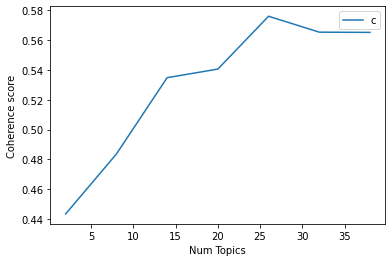

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4434
Num Topics = 8  has Coherence Value of 0.4836
Num Topics = 14  has Coherence Value of 0.5348
Num Topics = 20  has Coherence Value of 0.5406
Num Topics = 26  has Coherence Value of 0.576
Num Topics = 32  has Coherence Value of 0.5653
Num Topics = 38  has Coherence Value of 0.5652


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.129*"find" + 0.077*"life" + 0.044*"dead" + 0.031*"body" + 0.028*"death" + '
  '0.025*"heart" + 0.022*"save" + 0.021*"child" + 0.019*"person" + '
  '0.019*"pull"'),
 (1,
  '0.113*"call" + 0.070*"move" + 0.058*"talk" + 0.054*"leave" + 0.034*"mom" + '
  '0.021*"phone" + 0.020*"line" + 0.020*"turn" + 0.019*"lady" + '
  '0.017*"business"'),
 (2,
  '0.141*"give" + 0.067*"kid" + 0.042*"care" + 0.033*"forget" + 0.028*"eye" + '
  '0.027*"follow" + 0.026*"case" + 0.023*"number" + 0.019*"gun" + '
  '0.018*"school"'),
 (3,
  '0.155*"thing" + 0.094*"happen" + 0.067*"bad" + 0.051*"fine" + 0.044*"boy" + '
  '0.039*"nice" + 0.030*"crazy" + 0.029*"hit" + 0.024*"important" + '
  '0.013*"beat"'),
 (4,
  '0.220*"good" + 0.089*"feel" + 0.065*"night" + 0.035*"mother" + '
  '0.027*"pretty" + 0.027*"doctor" + 0.026*"idea" + 0.016*"marry" + '
  '0.014*"cry" + 0.013*"scared"'),
 (5,
  '0.078*"hear" + 0.073*"great" + 0.048*"show" + 0.046*"car" + 0.035*"change" '
  '+ 0.034*"point" + 0.031*"word" + 0.02

In [ ]:
print(optimal_model[corpus][0])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(0, 0.04999999999999999), (1, 0.04999999999999999), (2, 0.04999999999999999), (3, 0.04999999999999999), (4, 0.04999999999999999), (5, 0.04999999999999999), (6, 0.04999999999999999), (7, 0.04999999999999999), (8, 0.04999999999999999), (9, 0.04999999999999999), (10, 0.04999999999999999), (11, 0.04999999999999999), (12, 0.04999999999999999), (13, 0.04999999999999999), (14, 0.04999999999999999), (15, 0.04999999999999999), (16, 0.04999999999999999), (17, 0.04999999999999999), (18, 0.04999999999999999), (19, 0.04999999999999999)]


In [ ]:
print(optimal_model.show_topic(19))

[('man', 0.17909394250513347), ('wait', 0.09484086242299794), ('woman', 0.06968685831622176), ('love', 0.03279004106776181), ('kind', 0.02983829568788501), ('set', 0.024063141683778235), ('police', 0.018287987679671457), ('chance', 0.016683778234086243), ('afraid', 0.016491273100616016), ('moment', 0.01584958932238193)]


In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=speaker):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    print("hello")
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    print("hello1")
    # Add original text to the end of the output
    contents = pd.Series(texts)
    print("hello3")
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    print("hello4")
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts = speaker)
print('hello5')
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
print('hello6')
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print('hello7')
# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


hello
hello1
hello3
hello4
hello5
hello6
hello7


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.0500,"find, life, dead, body, death, heart, save, ch...",Already!
1,1,5.0,0.0686,"hear, great, show, car, change, point, word, t...",Great!
2,2,0.0,0.0500,"find, life, dead, body, death, heart, save, ch...",Yes.
3,3,12.0,0.0686,"people, fire, real, lie, read, town, power, bu...",- What did you buy?
4,4,0.0,0.0500,"find, life, dead, body, death, heart, save, ch...",Let's go there!
5,5,8.0,0.0621,"back, home, run, stay, tomorrow, stuff, mornin...","Hey, she's too tall."
6,6,0.0,0.0500,"find, life, dead, body, death, heart, save, ch...",You think so?
7,7,0.0,0.0500,"find, life, dead, body, death, heart, save, ch...",What?
8,8,0.0,0.0500,"find, life, dead, body, death, heart, save, ch...","If you do, I'll..."
9,9,0.0,0.0500,"find, life, dead, body, death, heart, save, ch...",I'll leave you.


In [ ]:
speaker[:10]

['Already!',
 'Great!',
 'Yes.',
 '- What did you buy?',
 "Let's go there!",
 "Hey, she's too tall.",
 'You think so?',
 'What?',
 "If you do, I'll...",
 "I'll leave you."]